# Attribute Evaluation (Feature selection)

In machine learning, we can sometimes improve model performance by removing features that do not contain helpful information or by focusing only on the most important features. This can help to:

* Reduce overfitting. A smaller number of features mean models have less chance to overfit on noise present in the training data.
* Improve accuracy. Some models are not good at distinguishing between useful and useless features. By selecting only the most important features, we can sometimes improve performance of such models.
    
This task is often called feature selection and can be automated using different approaches.

In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from datasets import load_dataset
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score

# Example 1

In [10]:
imdb_dataset = load_dataset('imdb')
data = pd.DataFrame(imdb_dataset['train'].shuffle(seed=42).select(range(1000)))
data['label'] = data['label'].apply(lambda x: 'pos' if x else 'neg')
X_train, X_test, y_train, y_test = train_test_split(data['text'], data['label'], test_size=0.2, random_state=42)

vectorizer = TfidfVectorizer()  # Use TF-IDF vectorizer for text to numerical feature conversion
X_train_vec = vectorizer.fit_transform(X_train).todense()
X_test_vec = vectorizer.transform(X_test).todense()

X_train_vec.shape

Reusing dataset imdb (C:\Users\Tadej\.cache\huggingface\datasets\imdb\plain_text\1.0.0\e3c66f1788a67a89c7058d97ff62b6c30531e05b549de56d3ab91891f0561f9a)
Loading cached shuffled indices for dataset at C:\Users\Tadej\.cache\huggingface\datasets\imdb\plain_text\1.0.0\e3c66f1788a67a89c7058d97ff62b6c30531e05b549de56d3ab91891f0561f9a\cache-67e2972668bc5f73.arrow


(800, 15331)

Our tf-idf vector contains a large amount of rows (features). Most features are not related to review scores and will not be useful when training a classification model. Can we determine which features are useful?

## Univariate Feature Selection

Sklearn contains functions that can evaluate whether certain features are useful for predicting a given class. Univariate feature selection methods do this using statistical tests.

Mutual information measures the mutual dependence between two variables. In other words, it tells us whether knowing something about variable X will reduce the uncertainty about variable Y. If X and Y are independent, MI is equal to 0. Higher values indicate some relation between X and Y. 

f score uses analysis of variance to discover feature importances. For a given feature, it compares the distributions across all possible class values. The more the distributions differ between classes, the better the score.

In [11]:
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import f_classif

In [12]:
# A list of words in our tf-idf matrix
list(vectorizer.vocabulary_)[:10]

['it',
 'is',
 'difficult',
 'to',
 'find',
 'any',
 'positives',
 'in',
 'this',
 'movie']

In [13]:
# Evaluate each word with f values
feature_scores = f_classif(np.asarray(X_train_vec), y_train)[0]
feature_scores

array([3.08308322, 0.02613735, 1.02534898, ..., 1.02534898, 1.02534898,
       0.97527847])

In [14]:
word_scores = {k: v for k, v in zip(vectorizer.get_feature_names_out(), feature_scores)}
sorted_words = sorted(word_scores, key = word_scores.get)

# Print 30 words with highest mutual information
print("Highest")
for i in range(1, 31):
    print(sorted_words[-i], word_scores[sorted_words[-i]])
    
# And 30 lowest:
print("Lowest")
for i in range(0, 30):
    print(sorted_words[i], word_scores[sorted_words[i]])
    

Highest
worst 64.93362405889471
bad 41.640307139833816
this 28.812475478405194
worse 26.817349058752153
loved 25.23965347388643
poor 23.3689417214993
waste 23.339783629170977
crap 21.689863910500616
no 20.629076813027872
nothing 20.51696260303282
family 20.26184337977805
why 18.993743387035913
and 18.983529847277353
terrible 18.03846012935701
boring 17.827667352763545
just 17.563398390667402
any 17.54300666774805
would 16.838128768588284
attempt 16.774572640359427
great 16.530265291237658
love 16.49856868821814
badly 16.463979105673207
excellent 16.44098671363097
fantastic 15.607772688774912
awful 14.893801399009167
best 13.922145915556285
except 13.704731678835122
wonderful 13.419289281775692
low 13.303379449960808
lame 13.132877686659905
Lowest
causes 7.252333858558624e-08
broader 2.764856972576682e-07
entertaining 3.463939944464135e-07
likes 4.7273287167748094e-07
wanting 1.1430511403119043e-06
larger 1.2409485118913e-06
repression 1.5532486162148435e-06
market 1.5794652810698148e-0

In [15]:
bad_features_train = X_train_vec[:,feature_scores < 1 ]
bad_features_test = X_test_vec[:,feature_scores < 1]
bad_features_train.shape

(800, 7847)

In [16]:
good_features_train = X_train_vec[:,feature_scores > 1 ]
good_features_test = X_test_vec[:,feature_scores > 1]
good_features_train.shape

(800, 7484)

In [17]:
from sklearn.neighbors import KNeighborsClassifier

# KNN model
knn_model = KNeighborsClassifier()
knn_model.fit(np.asarray(bad_features_train), y_train)
knn_predictions = knn_model.predict(np.asarray(bad_features_test))
knn_accuracy = accuracy_score(y_test, knn_predictions)
print("KNN Accuracy on bad features:", knn_accuracy)

# KNN model
knn_model = KNeighborsClassifier()
knn_model.fit(np.asarray(good_features_train), y_train)
knn_predictions = knn_model.predict(np.asarray(good_features_test))
knn_accuracy = accuracy_score(y_test, knn_predictions)
print("KNN on good features:", knn_accuracy)


KNN Accuracy on bad features: 0.465
KNN on good features: 0.535


Good features perform better than bad features, but are they better than all features?

In [18]:
# KNN model
knn_model = KNeighborsClassifier()
knn_model.fit(np.asarray(X_train_vec), y_train)
knn_predictions = knn_model.predict(np.asarray(X_test_vec))
knn_accuracy = accuracy_score(y_test, knn_predictions)
print("KNN Accuracy on all features:", knn_accuracy)

KNN Accuracy on all features: 0.575


Lets evaluate different feature subsets

In [19]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

In [20]:
for n_feats in range(100, X_train_vec.shape[1], 1000):
    feature_selector = SelectKBest(f_classif, k=n_feats)
    X_train_n_best = feature_selector.fit_transform(np.asarray(X_train_vec), y_train)
    X_test_n_best = feature_selector.transform(np.asarray(X_test_vec))
    
    knn_model = KNeighborsClassifier()
    knn_model.fit(X_train_n_best, y_train)
    knn_predictions = knn_model.predict(X_test_n_best)
    knn_accuracy = accuracy_score(y_test, knn_predictions)
    print(n_feats, knn_accuracy)

100 0.645
1100 0.585
2100 0.58
3100 0.585
4100 0.585
5100 0.57
6100 0.535
7100 0.535
8100 0.535
9100 0.535
10100 0.535
11100 0.56
12100 0.615
13100 0.59
14100 0.615
15100 0.545


Certain subsets of features improve performance over all features! This depends on the data and type of model, but feature selection can sometimes be an important part of classification.

# Example 2 - Dependent Features

The previous features assume the features are indepentend. In real-world scenarions, this is not always true and can make such methods innefective. For example, consider the following artificial example:

In [21]:
quadrant = pd.read_csv("quadrant.txt")
quadrant

,a1,a2,a3,a4,a5,a6,a7,a8,Class
0,-74,98,25,30,-11,34,67,35,True
1,-42,-87,24,88,71,74,87,-74,False
2,-44,72,23,-67,20,33,75,-60,True
3,-75,-88,-59,29,-92,-27,-61,-43,False
4,-41,69,-9,7,-24,-10,-6,-7,True
...,...,...,...,...,...,...,...,...,...
995,88,-55,-47,-90,98,-35,34,-79,True
996,37,-77,52,-31,61,-37,24,-55,True
997,-92,-66,-65,8,-64,73,-15,-81,False
998,6,46,-16,50,-36,65,-53,96,False


"Quadrant" is a dummy dataset where:

* Every feature is, by itself, independent from the class variable. We cannot predict the class based on 1 feature alone
* The only way to make correct predictions is by looking at both a1 and a2.

In [22]:
import matplotlib.pyplot as plt

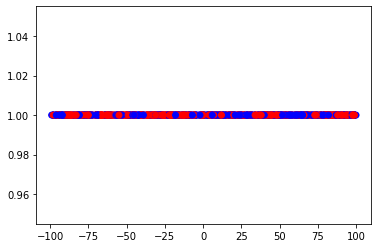

In [23]:
colors = ['red' if x else 'blue' for x in quadrant['Class']]
plt.scatter(quadrant['a1'],[1 for _ in quadrant['a1']], color=colors)

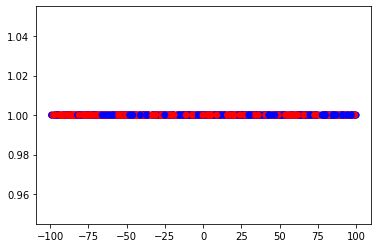

In [24]:
plt.scatter(quadrant['a2'],[1 for _ in quadrant['a1']], color=colors)

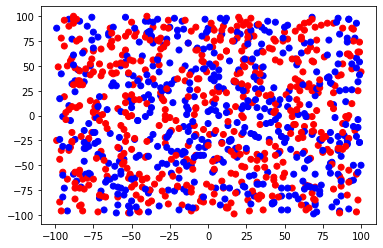

In [25]:
colors = ['red' if x else 'blue' for x in quadrant['Class']]
plt.scatter(quadrant['a2'], quadrant ['a3'], color=colors)

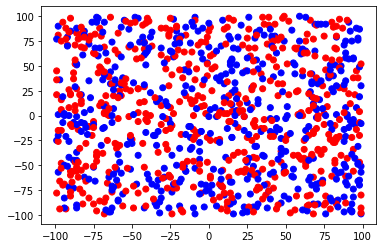

In [26]:
plt.scatter(quadrant['a4'], quadrant ['a5'], color=colors)

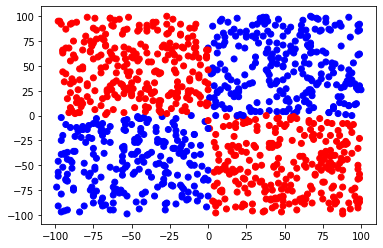

In [27]:
plt.scatter(quadrant['a1'], quadrant ['a2'], color=colors)

Measures that assume features are independent will fail to properly evaluate features

In [28]:
mutual_info_classif(quadrant.drop('Class', axis=1), quadrant['Class'])

array([0.        , 0.        , 0.        , 0.        , 0.00876614,
       0.00686018, 0.00554478, 0.        ])

In [29]:
f_classif(quadrant.drop('Class', axis=1), quadrant['Class'])[0]

array([0.08224689, 1.5022783 , 1.65611467, 4.75349276, 0.80372455,
       0.00653336, 1.92820717, 0.11729072])

Models using the selected measures cannot classify examples (unless the feature selection methods get lucky and guess the correct features)

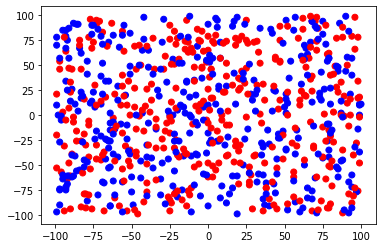

In [30]:
from sklearn.tree import DecisionTreeClassifier

train_x, test_x, train_y, test_y = train_test_split(quadrant.drop('Class', axis=1), quadrant['Class'])

feature_selector = SelectKBest(mutual_info_classif, k=2)
quadrant_2_feats_train = feature_selector.fit_transform(train_x, train_y)
colors = ['red' if x else 'blue' for x in train_y]
plt.scatter([x[0] for x in quadrant_2_feats_train], [x[1] for x in quadrant_2_feats_train], color=colors )

In [31]:
quadrant_2_feats_test = feature_selector.transform(test_x)
dt_model = DecisionTreeClassifier()
dt_model.fit(quadrant_2_feats_train, train_y)
dt_predictions = dt_model.predict(quadrant_2_feats_test)
dt_accuracy = accuracy_score(test_y, dt_predictions)
dt_accuracy

0.576

Instead, we can use methods that take feature dependency into account

In [32]:
#!pip install sklearn_relief

In [33]:
import sklearn_relief as relief

In [34]:
r = relief.Relief(n_features=2, n_jobs=1)

In [35]:
r.fit(np.asarray(train_x), np.asarray(train_y))
relief_2_feats_train = r.transform(np.asarray(train_x))
relief_2_feats_test = r.transform(np.asarray(test_x))

In [36]:
print("Relief feature weights")
print(r.w_)

Relief feature weights
[40.25 44.29 18.68 25.5  23.17 21.31 23.51 22.09]


The first two features are correctly identified as important! Relief takes into account feature dependencies and correctly identifies the first two as most useful.

In [37]:
dt_model = DecisionTreeClassifier()
dt_model.fit(relief_2_feats_train, train_y)
dt_predictions = dt_model.predict(relief_2_feats_test)
dt_accuracy = accuracy_score(test_y, dt_predictions)
dt_accuracy

0.992

# Example 3 - Model-based feature selection

Some models already evaluate features during training. For example, decision trees and random forests can assign importances to features that are used to split the trees. After training, we can obtain these features and use them in other models or use them to explain how a model obtained its predictions.

In [38]:
from sklearn.ensemble import RandomForestClassifier

In [39]:
X_train_vec

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

In [40]:
logistic_model = RandomForestClassifier()
logistic_model.fit(np.asarray(X_train_vec), y_train)

for score, name in list(sorted(zip(logistic_model.feature_importances_, vectorizer.get_feature_names_out()), reverse=True))[:10]:
    print(name, score)

worst 0.010121198140955776
bad 0.0076445095203482695
this 0.006713446266063814
to 0.005539519214997096
and 0.005333189102902598
movie 0.00473906061143304
nothing 0.00464859120572034
just 0.003980341182614744
been 0.003741308893176065
but 0.0036875990815247155


# Example 4 - Recursive feature elimination

Recursive feature elimination (RFE) tries to select a subset of best features by recursively removing unhelpful features. It trains a model multiple times, removing a certain amount least-helpful features (according to model-based feature importance) after each iteration.

In [41]:
 from sklearn.feature_selection import RFE

In [46]:
estimator = RandomForestClassifier()

In [47]:
selector = RFE(estimator, n_features_to_select = 12000, step=500, verbose=1)
selector = selector.fit(np.asarray(X_train_vec), y_train)

Fitting estimator with 15331 features.
Fitting estimator with 14831 features.
Fitting estimator with 14331 features.
Fitting estimator with 13831 features.
Fitting estimator with 13331 features.
Fitting estimator with 12831 features.
Fitting estimator with 12331 features.


In [48]:
X_train_rfe = selector.transform(np.asarray(X_train_vec))
X_test_rfe = selector.transform(np.asarray(X_test_vec))

estimator = RandomForestClassifier()
estimator.fit(np.asarray(X_train_vec), y_train)
preds = estimator.predict(np.asarray(X_test_vec))
score_vec = accuracy_score(y_test, preds)
print("Random forest score on all features:", score_vec)


estimator = RandomForestClassifier()
estimator.fit(X_train_rfe, y_train)
preds = estimator.predict(X_test_rfe)
score_rfe = accuracy_score(y_test, preds)
print("Random forest score on RFE features:", score_rfe)

Random forest score on all features: 0.73
Random forest score on RFE features: 0.785
